## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [3]:
from sklearn.model_selection import train_test_split

df_full_train,df_test=train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val=train_test_split(df_full_train,test_size=0.25,random_state=1)

y_train=np.log1p(df_train.price.values)
y_val=np.log1p(df_val.price.values)
y_test=np.log1p(df_test.price.values)

In [4]:
del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [5]:
from sklearn.feature_extraction import DictVectorizer

In [6]:
dv=DictVectorizer(sparse=False)

train_dicts=df_train.to_dict(orient='records')
X_train=dv.fit_transform(train_dicts)

val_dicts=df_val.to_dict(orient='records')
X_val=dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [7]:
from sklearn.tree import DecisionTreeRegressor

In [8]:
dt=DecisionTreeRegressor(max_depth=1,random_state=1)
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1, random_state=1)

Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

In [9]:
from sklearn.tree import export_text

In [10]:
print(export_text(dt ,feature_names=dv.get_feature_names() ))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



**Answer**:Room type is used for splitting the data

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
rf=RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [13]:
y_pred=rf.predict(X_val)

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

In [17]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [18]:
print('RMSE : ',round(rmse(y_val,y_pred),3) )

RMSE :  0.462


**answer** : RMSE $\approx$ 0.459

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [25]:
import matplotlib.pyplot as plt

In [26]:
list_rmse=[]
for n in range(10,201,10):
    rf=RandomForestRegressor(n_estimators=n,random_state=1,n_jobs=-1)
    rf.fit(X_train,y_train)
    
    y_pred=rf.predict(X_val)
    
    rmse_n=rmse(y_val,y_pred)
    list_rmse.append((n,rmse_n))

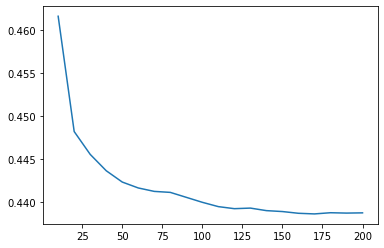

In [27]:
df_score=pd.DataFrame(list_rmse,columns=['n','rmse'])
plt.plot(df_score.n.values,df_score.rmse.values)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

**answer** : at n_estimators equal 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [28]:
scores=[]
max_depth= [10, 15, 20, 25]
for i in max_depth:
    for j in range(10,201,10):
        rf=RandomForestRegressor(n_estimators=j,max_depth=i,random_state=1,n_jobs=-1)
        rf.fit(X_train,y_train)

        y_pred=rf.predict(X_val)

        rmse_n=rmse(y_val,y_pred)
        scores.append((i,j,rmse_n))

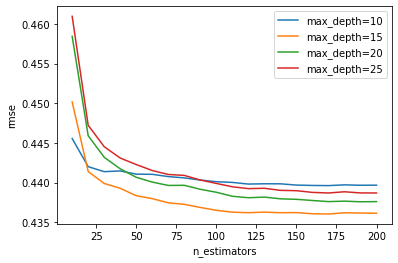

In [30]:
df_score=pd.DataFrame(scores,columns=['max_depth','n_estimators','rmse'])
for i in max_depth:
    df_i=df_score[df_score.max_depth==i]
    plt.plot(df_i.n_estimators,df_i.rmse,label=f'max_depth={i}')
plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

**answer**: 15

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [33]:
rf=RandomForestRegressor(n_estimators=10,max_depth=20,random_state=1,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [37]:
len(dv.get_feature_names())

15

In [49]:
dict(zip(dv.get_feature_names(),rf.feature_importances_)) 

{'availability_365': 0.07626394738694817,
 'calculated_host_listings_count': 0.030101925485178132,
 'latitude': 0.15277535379400206,
 'longitude': 0.15410095957496295,
 'minimum_nights': 0.05325191764648017,
 'neighbourhood_group=Bronx': 0.00026484584916173826,
 'neighbourhood_group=Brooklyn': 0.0009659595374179881,
 'neighbourhood_group=Manhattan': 0.034047271823485964,
 'neighbourhood_group=Queens': 0.0011660990169743985,
 'neighbourhood_group=Staten Island': 8.402789469553783e-05,
 'number_of_reviews': 0.0415942415007103,
 'reviews_per_month': 0.05443038773303107,
 'room_type=Entire home/apt': 0.3918981936917194,
 'room_type=Private room': 0.004032027763645291,
 'room_type=Shared room': 0.0050228413015867635}

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

**answer** : room type = Entire home/apt

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [82]:
import xgboost as xgb

In [83]:
def parse_xgb_output(output):
    results=[]
    tree=[]
    aucs_train=[]
    aucs_val=[]
    
    for line in output.stdout.strip().split('\n'):
        it_line,train_line,val_line=line.split('\t')
        
        it=int(it_line.strip('[]'))
        train=float(train_line.split(':')[1])
        val=float(val_line.split(':')[1])
        
        results.append((it,train,val))
    
    columns=['num_iter','train_rmse','val_rmse']
    df_results=pd.DataFrame(results,columns=columns)
    return df_results

In [84]:
features=dv.get_feature_names()
dtrain=xgb.DMatrix(X_train,label=y_train,feature_names=features)
dval=xgb.DMatrix(X_val,label=y_val,feature_names=features)

In [85]:
scores={}

In [86]:
watchlist=[(dtrain,'train'),(dval,'val')]

In [91]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'eval_metric':'rmse',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model=xgb.train(xgb_params,dtrain,
                verbose_eval=5,
                evals=watchlist,
                num_boost_round=200)

In [92]:
key='eta=%s'%(xgb_params['eta'])
scores[key]=parse_xgb_output(output)

Now change `eta` first to `0.1` and then to `0.01`

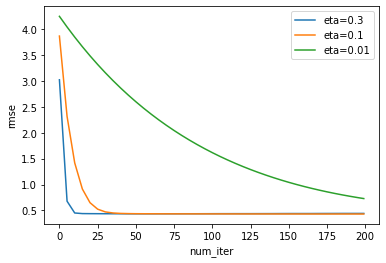

In [97]:
for i,j in scores.items():
    plt.plot(j.num_iter,j.val_rmse,label=i)
plt.xlabel('num_iter')
plt.ylabel('rmse')
plt.legend()

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

**answer**:0.3

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

